In [23]:
import math
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

#Problem 2

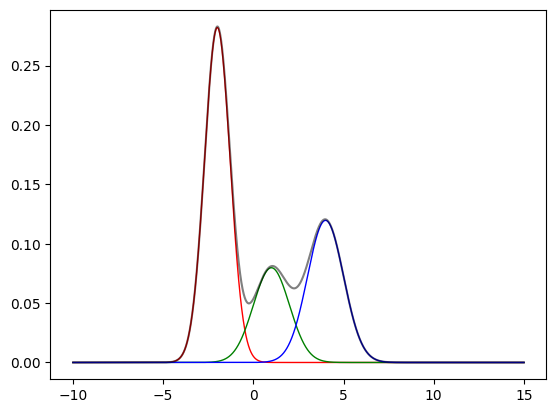

In [24]:
#Original set
Ao=stats.norm(-2, np.sqrt(0.5))
Bo=stats.norm(1, np.sqrt(1))
Co=stats.norm(4, np.sqrt(1))

#display function
def display(Ao,Bo,Co,w1,w2,w3):
    x = np.arange(-10, 15, 0.0001)
    ya = w1*Ao.pdf(x)
    yb = w2*Bo.pdf(x)
    yc = w3*Co.pdf(x)

    yd = w1*Ao.pdf(x) + w2*Bo.pdf(x)+w3*Co.pdf(x)

    plt.plot(x, ya, color='red', linewidth=1)
    plt.plot(x, yb, color='green',  linewidth=1)
    plt.plot(x, yc, color='blue', linewidth=1)
    plt.plot(x, yd, color='black', linestyle='-', alpha=0.5)

    plt.show()

display(Ao,Bo,Co,0.5,0.2,0.3)

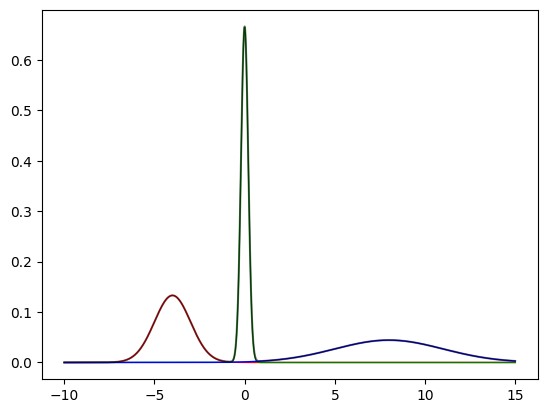

In [25]:
data=[-3, -2.5, -1, 0,2,4,5]

##Mixture models initialization
A=stats.norm(-4, 1)
B=stats.norm(0, 0.2)
C=stats.norm(8, 3)

##Weights initialization
w1,w2,w3=1/3, 1/3, 1/3

display(A,B,C,w1,w2,w3)

In [26]:
#Calculate responsibilities
def responsibilities(x, A,B,C, w1, w2, w3):
    asum = w1*A.pdf(x)
    bsum = w2*B.pdf(x)
    csum = w3*C.pdf(x)

    dsum = asum+bsum+csum

    return [round(asum/dsum,5), round(bsum/dsum,5), round(csum/dsum,5)]

allresponsibilities = np.array([responsibilities(dx, A,B,C, w1, w2, w3) for dx in data]).reshape((len(data),3))
print(allresponsibilities)

[[9.9934e-01 0.0000e+00 6.6000e-04]
 [9.9776e-01 0.0000e+00 2.2400e-03]
 [7.4906e-01 1.2600e-03 2.4969e-01]
 [7.0000e-05 9.9803e-01 1.9000e-03]
 [0.0000e+00 0.0000e+00 1.0000e+00]
 [0.0000e+00 0.0000e+00 1.0000e+00]
 [0.0000e+00 0.0000e+00 1.0000e+00]]


In [27]:
#Update mixture means
def updatemean(k, allresponsibilities, data):
    r_k = allresponsibilities[:, k]  #responsibilities of kth component
    numerator = np.sum([r_k[x]*data[x] for x in range(len(data))])
    denominator = np.sum(r_k)
    return numerator/denominator

means = [updatemean(k, allresponsibilities, data) for k in range(0,3)]

print(means)

[-2.2727448174406364, -0.0012608952356172882, 3.300895071117133]


In [28]:
#Update mixture sigmasquares
def updatesigmasq(k, allresponsibilities, data, means):
    r_k = allresponsibilities[:, k]  #responsibilities of kth component
    numerator = np.sum([r_k[x] * (data[x] - means[k]) ** 2 for x in range(len(data))])
    denominator = np.sum(r_k)
    return max(numerator / denominator, 1e-6)  #I set a lower bound for the variance as
                                               #I was getting a divide by zero error

sigmasqs = [updatesigmasq(k, allresponsibilities, data, means) for k in range(3)]

print(sigmasqs)

[0.6531968104785885, 0.0012593053788220857, 3.013991590896833]


In [29]:
#Update mixture weights
def updateweights(k, allresponsibilities):
    numerator = np.sum(allresponsibilities[:, k])
    denominator = len(allresponsibilities)
    return numerator/denominator

weights = [updateweights(k , allresponsibilities) for k in range(0,3)]

print(weights)

[0.39231857142857146, 0.1427557142857143, 0.46492714285714287]


In [30]:
#Negative Log Likelihood
def checkconverge(weights, means, sigmasqs, data):
    cumsum = 0
    for d in data:
        temp = 0
        for k in range(3):
            temp+= weights[k]*stats.norm(means[k], np.sqrt(sigmasqs[k])).pdf(d)
        cumsum = cumsum+ np.log(temp)*-1
    return cumsum

checkconverge(weights, means, sigmasqs, data)

checkconverge([w1,w2,w3],[-4,0,8],[1,0.2,3],data)

28.325535655854626

Iteration number: 1, NLL: 13.585710
Iteration number: 2, NLL: 9.804258
Iteration number: 3, NLL: 9.729679
Iteration number: 4, NLL: 9.727305
Iteration number: 5, NLL: 9.727293
Iteration number: 6, NLL: 9.727293
Convergence


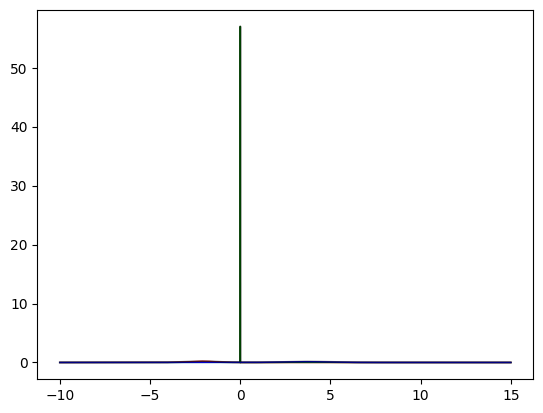

Final means: [-2.167195269587489, 0.0, 3.6640137255555185]
Final variances: [0.7221582992318428, 1e-06, 1.567044595607325]
Final weights: [0.42835285714285715, 0.14283285714285715, 0.4288142857142857]


In [31]:
tolerance = 1e-6
maxIterations = 50
prevNLL = 10e10
iterations = 0

#EM Algorithm
for iterations in range(maxIterations):
    #E-Step computing responsibilities
    allresponsibilities = np.array([responsibilities(dx, A, B, C, w1, w2, w3) for dx in data])

    #M-Step parameter update
    means = [updatemean(k, allresponsibilities, data) for k in range(3)]
    sigmasqs = [updatesigmasq(k, allresponsibilities, data, means) for k in range(3)]
    weights = [updateweights(k, allresponsibilities) for k in range(3)]

    #Update of normal distributions and weights
    A = stats.norm(means[0], np.sqrt(sigmasqs[0]))
    B = stats.norm(means[1], np.sqrt(sigmasqs[1]))
    C = stats.norm(means[2], np.sqrt(sigmasqs[2]))
    w1, w2, w3 = weights

    currentNLL = checkconverge(weights, means, sigmasqs, data)
    print(f"Iteration number: {iterations + 1}, NLL: {currentNLL:.6f}")

    #Convergence check
    if abs(prevNLL - currentNLL) < tolerance:
        print("Convergence")
        break
    prevNLL = currentNLL

display(A, B, C, w1, w2, w3)

print("Final means:", means)
print("Final variances:", sigmasqs)
print("Final weights:", weights)

#Problem 3

There are several ways to speed up the convergence of the algorithm. The simplest approach is to keep the parameters unchanged but increase the tolerance value. Another approach involves adjusting the initial means to be closer to those of the original data set. One way to automate this process is by using the K-means algorithm or other clustering methods to identify good starting points. The idea is to efficiently group the data and produce a better initial estimate which can, in turn, accelerate the EM algorithm (In the second example, to simulate this process, I took the approximate results from running the first instance of the problem and used them as the starting parameters).

In [32]:
#Original set
Ao=stats.norm(-2, np.sqrt(0.5))
Bo=stats.norm(1, np.sqrt(1))
Co=stats.norm(4, np.sqrt(1))

data=[-3, -2.5, -1, 0,2,4,5]

##Mixture models initialization
A=stats.norm(-4, 1)
B=stats.norm(0, 0.2)
C=stats.norm(8, 3)

##Weights initialization
w1,w2,w3=1/3, 1/3, 1/3

Iteration number: 1, NLL: 13.585710
Iteration number: 2, NLL: 9.804258
Iteration number: 3, NLL: 9.729679
Iteration number: 4, NLL: 9.727305
Iteration number: 5, NLL: 9.727293
Convergence


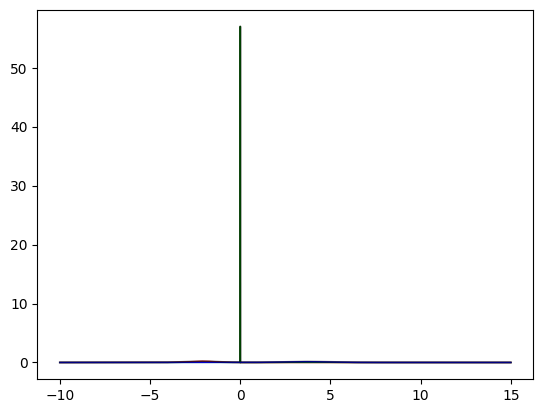

Final means: [-2.167214733092762, 0.0, 3.663936037311568]
Final variances: [0.7221476234556701, 1e-06, 1.567380826424307]
Final weights: [0.42834571428571433, 0.14283285714285715, 0.4288214285714286]


In [33]:
tolerance = 1e-3
maxIterations = 50
prevNLL = 10e10
iterations = 0

#EM Algorithm
for iterations in range(maxIterations):
    #E-Step computing responsibilities
    allresponsibilities = np.array([responsibilities(dx, A, B, C, w1, w2, w3) for dx in data])

    #M-Step parameter update
    means = [updatemean(k, allresponsibilities, data) for k in range(3)]
    sigmasqs = [updatesigmasq(k, allresponsibilities, data, means) for k in range(3)]
    weights = [updateweights(k, allresponsibilities) for k in range(3)]

    #Update of normal distributions and weights
    A = stats.norm(means[0], np.sqrt(sigmasqs[0]))
    B = stats.norm(means[1], np.sqrt(sigmasqs[1]))
    C = stats.norm(means[2], np.sqrt(sigmasqs[2]))
    w1, w2, w3 = weights

    currentNLL = checkconverge(weights, means, sigmasqs, data)
    print(f"Iteration number: {iterations + 1}, NLL: {currentNLL:.6f}")

    #Convergence check
    if abs(prevNLL - currentNLL) < tolerance:
        print("Convergence")
        break
    prevNLL = currentNLL

display(A, B, C, w1, w2, w3)

print("Final means:", means)
print("Final variances:", sigmasqs)
print("Final weights:", weights)

In [34]:
#Original set
Ao=stats.norm(-2, np.sqrt(0.5))
Bo=stats.norm(1, np.sqrt(1))
Co=stats.norm(4, np.sqrt(1))

data=[-3, -2.5, -1, 0,2,4,5]

##Mixture models initialization
A=stats.norm(-2, 0.7)
B=stats.norm(0, 0.00001)
C=stats.norm(3.6, 1.5)

##Weights initialization
w1,w2,w3=0.43, 0.14, 0.43

Iteration number: 1, NLL: 9.728868
Iteration number: 2, NLL: 9.727300
Iteration number: 3, NLL: 9.727293
Iteration number: 4, NLL: 9.727293
Convergence


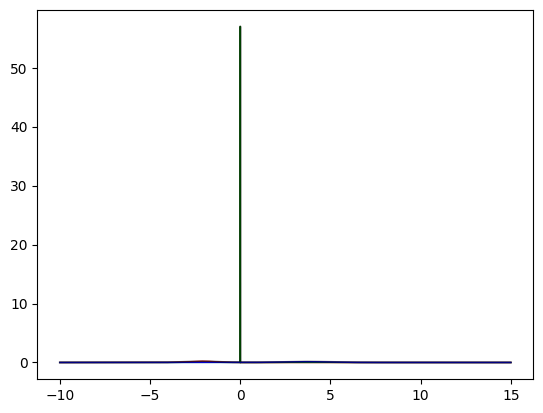

Final means: [-2.167195269587489, 0.0, 3.6640137255555185]
Final variances: [0.7221582992318428, 1e-06, 1.567044595607325]
Final weights: [0.42835285714285715, 0.14283285714285715, 0.4288142857142857]


In [35]:
tolerance = 1e-6
maxIterations = 50
prevNLL = 10e10
iterations = 0

#EM Algorithm
for iterations in range(maxIterations):
    #E-Step computing responsibilities
    allresponsibilities = np.array([responsibilities(dx, A, B, C, w1, w2, w3) for dx in data])

    #M-Step parameter update
    means = [updatemean(k, allresponsibilities, data) for k in range(3)]
    sigmasqs = [updatesigmasq(k, allresponsibilities, data, means) for k in range(3)]
    weights = [updateweights(k, allresponsibilities) for k in range(3)]

    #Update of normal distributions and weights
    A = stats.norm(means[0], np.sqrt(sigmasqs[0]))
    B = stats.norm(means[1], np.sqrt(sigmasqs[1]))
    C = stats.norm(means[2], np.sqrt(sigmasqs[2]))
    w1, w2, w3 = weights

    currentNLL = checkconverge(weights, means, sigmasqs, data)
    print(f"Iteration number: {iterations + 1}, NLL: {currentNLL:.6f}")

    #Convergence check
    if abs(prevNLL - currentNLL) < tolerance:
        print("Convergence")
        break
    prevNLL = currentNLL

display(A, B, C, w1, w2, w3)

print("Final means:", means)
print("Final variances:", sigmasqs)
print("Final weights:", weights)